In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [18]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Greenland = pd.read_excel(filepath, sheet_name='Greenland-Extent-km^2')

In [19]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [20]:
fp.month_mapping(Greenland)
fp.date_time(Greenland)

,Extent,Date
0,1076123.146,1979-01-01
1,1099248.063,1979-02-01
2,1036964.901,1979-03-01
3,958927.937,1979-04-01
4,823812.694,1979-05-01
...,...,...
533,721350.515,2023-06-01
534,459033.164,2023-07-01
535,282045.909,2023-08-01
536,270397.608,2023-09-01


In [21]:
scaler = MinMaxScaler()
Greenland['Extent'] = scaler.fit_transform(Greenland['Extent'].values.reshape(-1, 1))

In [22]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 2
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [23]:
extent = Greenland['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((525, 12, 1), (525,))

In [24]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Greenland_LT2/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 42s 530ms/step - loss: 0.2127 - root_mean_squared_error: 0.4612 - val_loss: 0.0443 - val_root_mean_squared_error: 0.2104
Epoch 2/50
53/53 [==============================] - 31s 601ms/step - loss: 0.0440 - root_mean_squared_error: 0.2098 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1691
Epoch 3/50
53/53 [==============================] - 32s 606ms/step - loss: 0.0360 - root_mean_squared_error: 0.1898 - val_loss: 0.0261 - val_root_mean_squared_error: 0.1614
Epoch 4/50
53/53 [==============================] - 30s 569ms/step - loss: 0.0326 - root_mean_squared_error: 0.1805 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1549
Epoch 5/50
53/53 [==============================] - 29s 563ms/step - loss: 0.0284 - root_mean_squared_error: 0.1685 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1454
Epoch 6/50
53/53 [==============================] - 26s 496ms/step - loss: 0.0245 - root_mean_squared_error: 0.1566 - val_loss: 0.0198 

53/53 [==============================] - 3s 59ms/step - loss: 0.0106 - root_mean_squared_error: 0.1031 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1107
Epoch 37/50
53/53 [==============================] - 3s 60ms/step - loss: 0.0109 - root_mean_squared_error: 0.1045 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1240
Epoch 38/50
53/53 [==============================] - 3s 61ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1244
Epoch 39/50
53/53 [==============================] - 3s 62ms/step - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1116
Epoch 40/50
53/53 [==============================] - 3s 61ms/step - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1041
Epoch 41/50
53/53 [==============================] - 3s 61ms/step - loss: 0.0107 - root_mean_squared_error: 0.1034 - val_loss: 0.0102 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

9.287828381856283 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

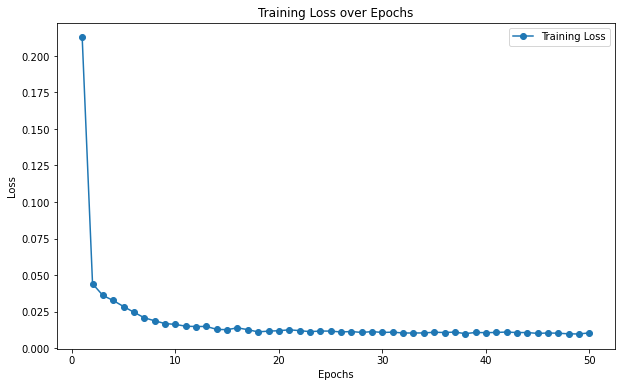

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

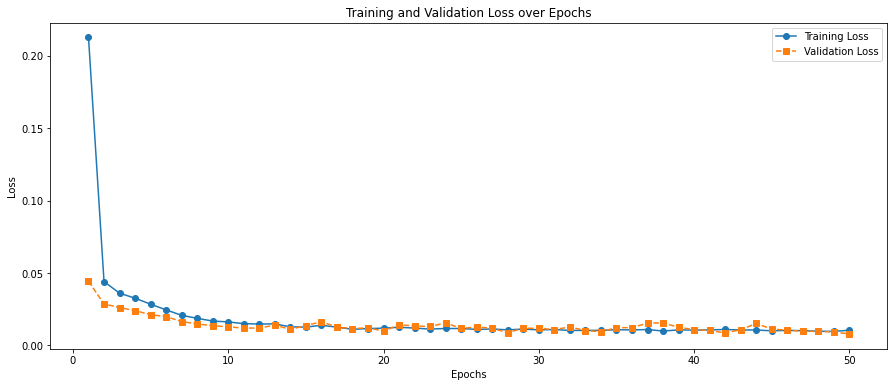

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [25]:
from tensorflow.keras.models import load_model
model1 = load_model('Greenland_LT2/')

In [26]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 26ms/step


In [27]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.08969632070900255
MAE : 0.07170313543363609


In [28]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [29]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,382683.343750,604702.636
1,261326.625000,436530.907
2,216530.234375,283162.646
3,227075.968750,212475.431
4,319651.687500,386546.857
5,440547.062500,547183.986
6,526834.937500,584596.262
7,600564.250000,584830.109
8,642653.750000,641562.292
9,655852.437500,734946.437


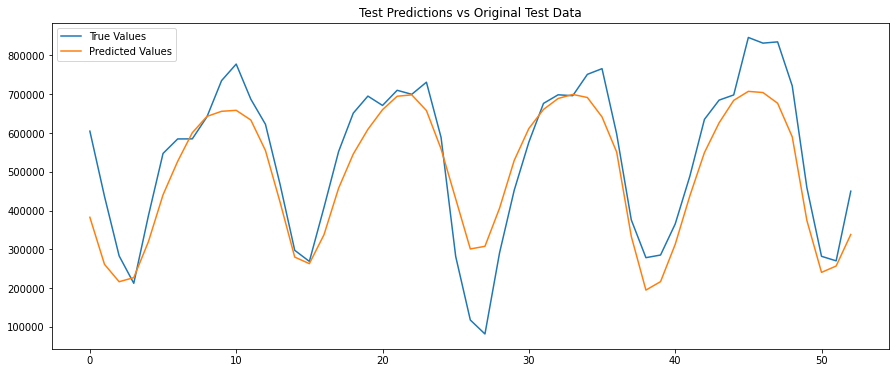

In [30]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [31]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 38ms/step


In [32]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

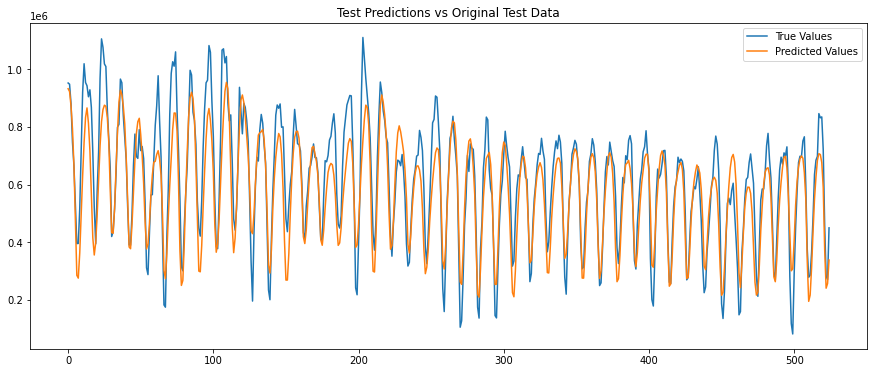

In [33]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()